In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings("ignore")

# Load Dataset

In [2]:
data_url = "/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(data_url)
print("Dataset Loaded - First 5 Rows:")
print(df.head())

Dataset Loaded - First 5 Rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV Strea

# Data Cleaning

In [3]:
df.drop(columns=['customerID'], inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Binary Encoding

In [4]:
yes_no_cols = ['Partner', 'Dependents', 'PaperlessBilling', 'Churn']
for col in yes_no_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# Convert to Categorical

In [5]:
categorical_cols = ['gender', 'InternetService', 'Contract', 'PaymentMethod', 
                    'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df[categorical_cols] = df[categorical_cols].astype('category')


# Feature Engineering

In [6]:
service_features = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df['TotalServices'] = df[service_features].apply(lambda row: (row == 'Yes').sum(), axis=1)
df['AverageMonthlySpend'] = df['TotalCharges'] / df['tenure'].replace(0, 1)
df.drop(columns=service_features, inplace=True)

# EDA: Churn Distribution

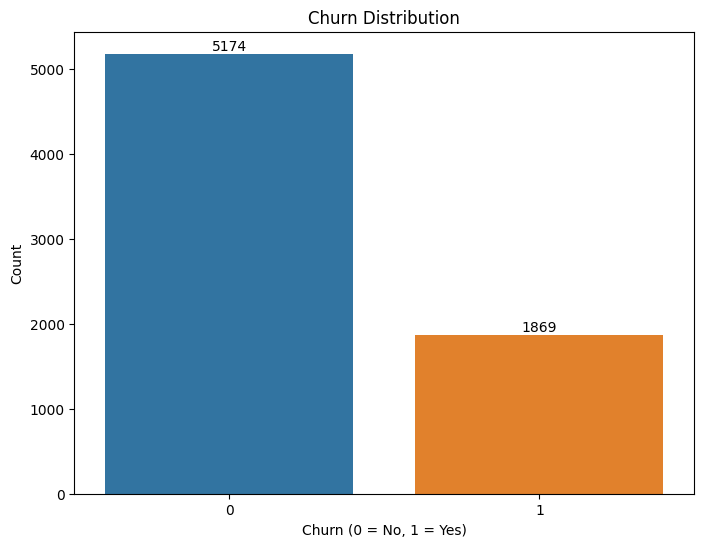

In [7]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

# EDA: Numerical Features Distribution

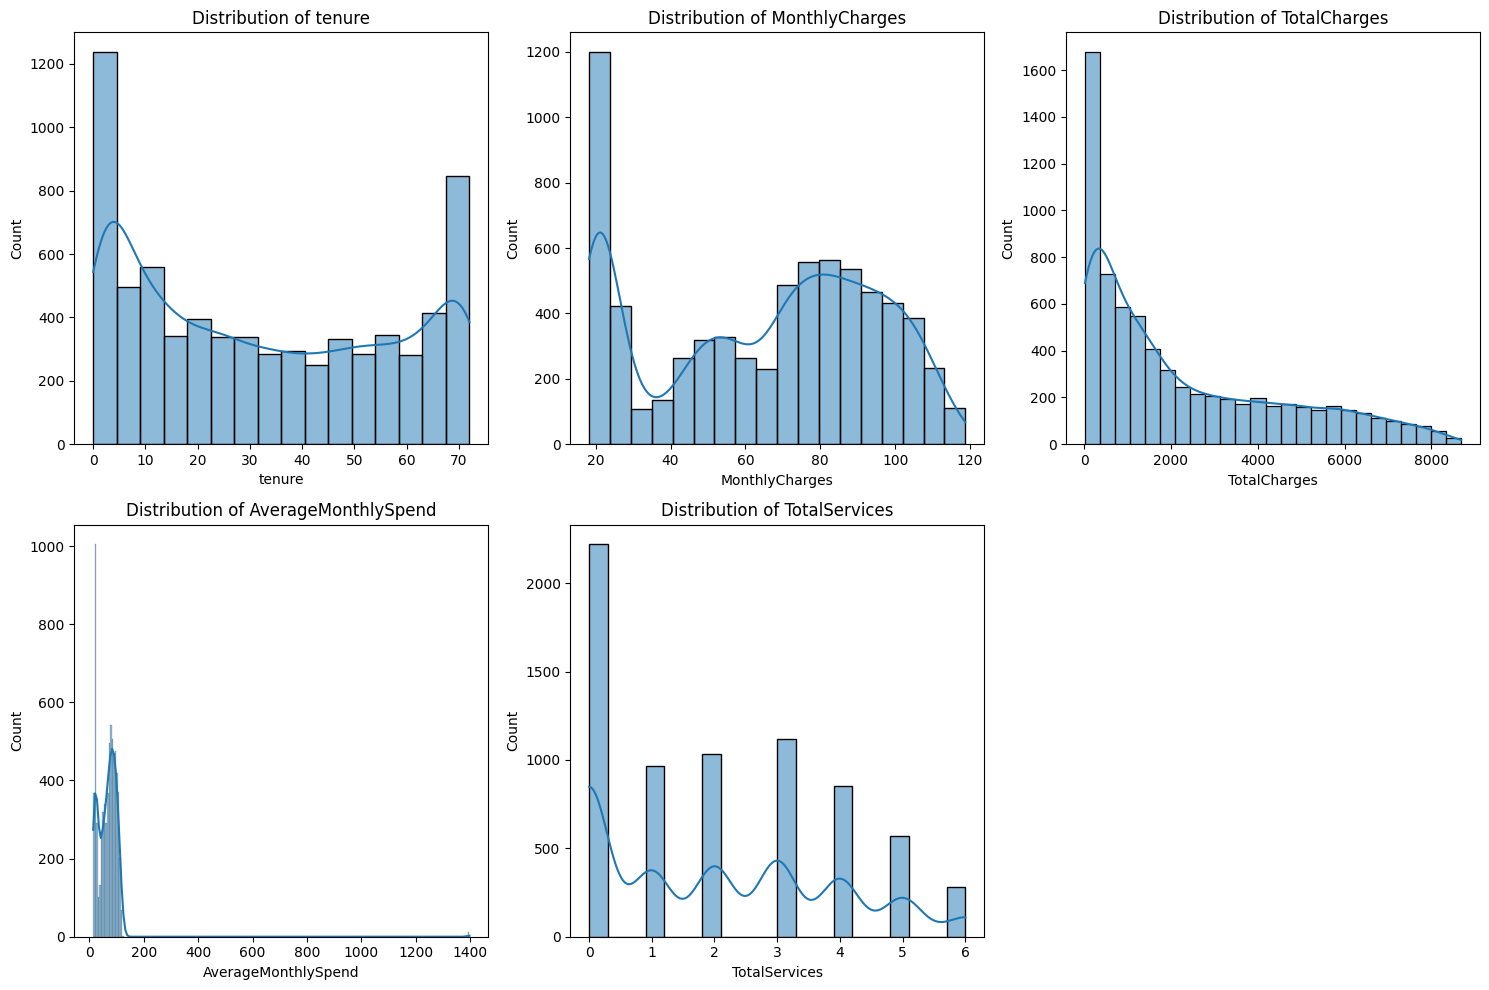

In [8]:
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'AverageMonthlySpend', 'TotalServices']
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Correlation Heatmap

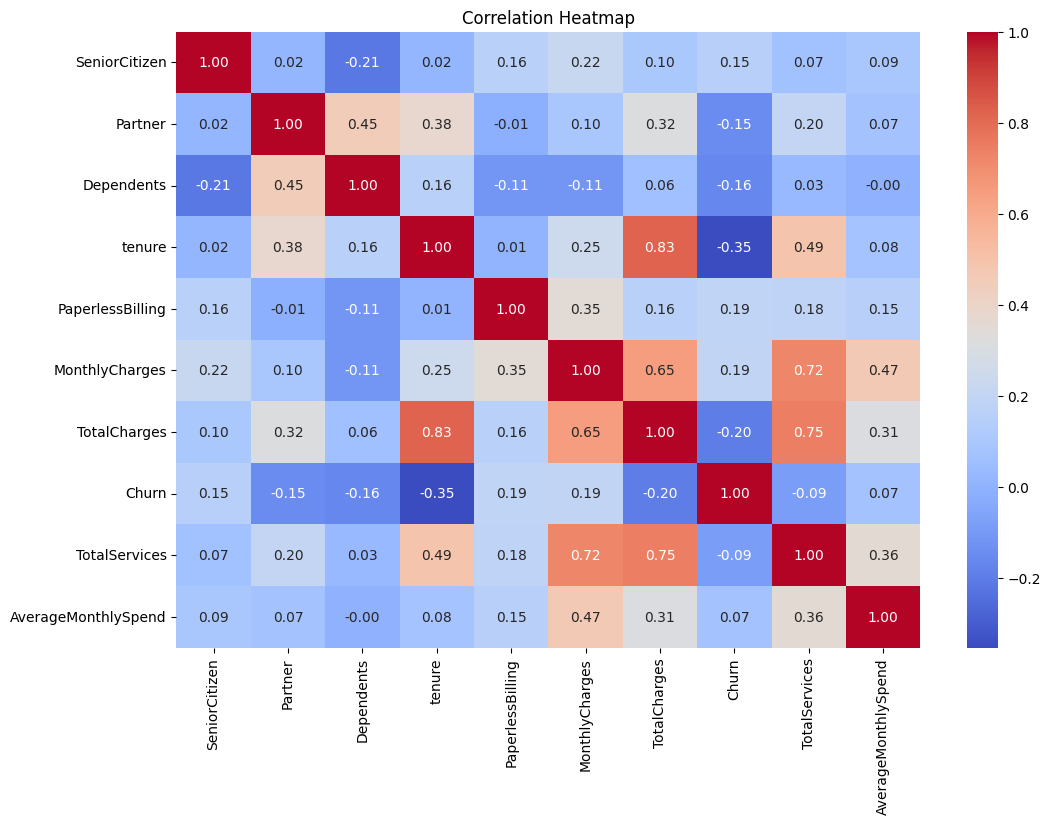

In [9]:
numerical_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Data Splitting and Scaling

In [10]:
X = df.drop(columns=['Churn'])
y = df['Churn']
X = pd.get_dummies(X, drop_first=True)

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Model Evaluation Function

In [11]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"\n{model_name} Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    return model

# Baseline Models

In [12]:
log_reg = LogisticRegression(random_state=42)
evaluate_model(log_reg, X_train, X_test, y_train, y_test, "Logistic Regression")

rf = RandomForestClassifier(random_state=42)
evaluate_model(rf, X_train, X_test, y_train, y_test, "Random Forest")

xgb = XGBClassifier(random_state=42)
evaluate_model(xgb, X_train, X_test, y_train, y_test, "XGBoost")


Logistic Regression Evaluation:
Accuracy: 0.8111
Precision: 0.8104
Recall: 0.8189
F1-Score: 0.8146
ROC-AUC: 0.8110
Confusion Matrix:
[[820 201]
 [190 859]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81      1021
           1       0.81      0.82      0.81      1049

    accuracy                           0.81      2070
   macro avg       0.81      0.81      0.81      2070
weighted avg       0.81      0.81      0.81      2070


Random Forest Evaluation:
Accuracy: 0.8406
Precision: 0.8434
Recall: 0.8418
F1-Score: 0.8426
ROC-AUC: 0.8406
Confusion Matrix:
[[857 164]
 [166 883]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1021
           1       0.84      0.84      0.84      1049

    accuracy                           0.84      2070
   macro avg       0.84      0.84      0.84      2070
weighted avg       0.84      0.84      0.84    

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

# Hyperparameter Tuning

In [13]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_random_search = RandomizedSearchCV(estimator=rf, param_distributions=rf_param_grid,
                                      n_iter=10, scoring='accuracy', cv=3, n_jobs=-1, random_state=42)
rf_random_search.fit(X_train, y_train)
best_rf_params = rf_random_search.best_params_
print("\nBest Parameters for Random Forest:", best_rf_params)
tuned_rf = RandomForestClassifier(**best_rf_params, random_state=42)
evaluate_model(tuned_rf, X_train, X_test, y_train, y_test, "Tuned Random Forest")

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}
xgb_random_search = RandomizedSearchCV(estimator=xgb, param_distributions=xgb_param_grid,
                                       n_iter=10, scoring='accuracy', cv=3, n_jobs=-1, random_state=42)
xgb_random_search.fit(X_train, y_train)
best_xgb_params = xgb_random_search.best_params_
print("\nBest Parameters for XGBoost:", best_xgb_params)
tuned_xgb = XGBClassifier(**best_xgb_params, random_state=42)
evaluate_model(tuned_xgb, X_train, X_test, y_train, y_test, "Tuned XGBoost")


Best Parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}

Tuned Random Forest Evaluation:
Accuracy: 0.8415
Precision: 0.8417
Recall: 0.8465
F1-Score: 0.8441
ROC-AUC: 0.8415
Confusion Matrix:
[[854 167]
 [161 888]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1021
           1       0.84      0.85      0.84      1049

    accuracy                           0.84      2070
   macro avg       0.84      0.84      0.84      2070
weighted avg       0.84      0.84      0.84      2070


Best Parameters for XGBoost: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 1.0}

Tuned XGBoost Evaluation:
Accuracy: 0.8295
Precision: 0.8295
Recall: 0.8351
F1-Score: 0.8323
ROC-AUC: 0.8294
Confusion Matrix:
[[841 180]
 [173 876]]
Classification Report:
              precision    recall  f1-score   support

       

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

# Ensemble Modeling

In [14]:
ensemble_model = VotingClassifier(
    estimators=[('lr', log_reg), ('rf', tuned_rf), ('xgb', tuned_xgb)],
    voting='soft'
)
evaluate_model(ensemble_model, X_train, X_test, y_train, y_test, "Ensemble Model")


Ensemble Model Evaluation:
Accuracy: 0.8430
Precision: 0.8396
Recall: 0.8532
F1-Score: 0.8463
ROC-AUC: 0.8429
Confusion Matrix:
[[850 171]
 [154 895]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1021
           1       0.84      0.85      0.85      1049

    accuracy                           0.84      2070
   macro avg       0.84      0.84      0.84      2070
weighted avg       0.84      0.84      0.84      2070



VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf',
                              RandomForestClassifier(min_samples_split=5,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=1.0, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.2, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft')

# Cross-Validation for Ensemble Model

In [15]:
ensemble_cv_scores = cross_val_score(ensemble_model, X_res, y_res, cv=5, scoring='accuracy')
print(f"\nEnsemble Model Cross-Validation Accuracy: {ensemble_cv_scores.mean():.4f}")


Ensemble Model Cross-Validation Accuracy: 0.8357


# Save Model

In [16]:
model_filename = "final_churn_ensemble_model.pkl"
joblib.dump(ensemble_model, model_filename)
print(f"\nModel saved to {model_filename}")


Model saved to final_churn_ensemble_model.pkl
